[The 1st IAA-CSIC Severo Ochoa School on Statistics, Data Mining and Machine Learning](https://www.granadacongresos.com/sostat)

# Lecture 3: Classification
### November 6, 2019 

[Zeljko Ivezic, University of Washington](http://faculty.washington.edu/ivezic/) 

[This notebook](https://github.com/carmensg/IAA_School2019/tree/master/lectures/Day3-ZeljkoIvezic/notebooks/classification.ipynb)

In [1]:
# first things first...
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
# astroML tools 
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
from astroML.plotting.mcmc import convert_to_stdev
setup_text_plots(fontsize=8, usetex=True)
import warnings; warnings.simplefilter('ignore')

## Classification and density estimation

In density estimation we estimate joint probability distributions from multivariate data sets to identify the inherent clustering. This is essentially <u> unsupervised classification </u>

If we have labels for some of these data points (e.g., an object is tall, short, red, or blue) we can develop a relationship between the label and the properties of a source. This is <u> supervised classification </u>

Here “supervised” means that there is prior information about the number and properties of clusters: for a training sample, we know the so-called “class labels” (for each data point in the training sample, we know to which cluster it belongs; characterizing these known clusters is typically easier than finding and characterizing unknown clusters)


Classification, regression, and density estimation are all related. For example, the regression function  
$ŷ =f(y|x⃗ )$ is the best estimated value of $y$ given a value of $x⃗$. 

In classification $y$ is categorical and $f(y|x⃗)$ is the called the discriminant function

Using density estimation for classification is referred to as **generative classification** (we have a full model of the density for each class or we have a model which describes how data could be generated from each class).

Classification that finds the decision boundary that separates classes is called **discriminative classification** 

Both have their place and role in astrophysical classification. 


 ## Classification loss: how well are we doing

The first question we need to address is how we score (defined the success of our classification)

We can define a _loss function_. A zero-one loss function assigns a value of one for a misclassification and zero for a correct classification (i.e. we will want to minimize the loss).

If $\hat{y}$ is the best guess value of $y$, the classification loss, $L(y,\widehat{y})$, is

> $L(y,\widehat{y}) = \delta(y \neq \widehat{y})$

which means

>$\begin{eqnarray} L(y,\hat{y}) & = & \left\{ \begin{array}{cl} 1 & \mbox{if $y\neq\hat{y}$}, \\  0 & \mbox{otherwise.}       	           \end{array} \right. \end{eqnarray}$


The expectation (mean) value of the loss $\mathbb{E} \left[ L(y,\hat{y}) \right] = p(y\neq \hat{y})$  is called the <u>classification risk</u> 

This is related to regression loss functions: $L(y, \hat{y}) = (y - \hat{y})^2$ and <u>risk<u> $\mathbb{E}[(y - \hat{y})^2]$.

We can then define:

> $ {\rm completeness} = \frac{\rm true\ positives}
  {\rm true\ positives + false\ negatives}
$

> $  {\rm contamination} = \frac{\rm false\ positives}
  {\rm true\ positives + false\ positives}
$

or

> $ {\rm true\ positive\ rate} = \frac{\rm true\ positives}
  {\rm true\ positives + false\ negatives}
$

> $  {\rm false\ positive\ rate} = \frac{\rm false\ positives}
  {\rm true\ negatives + false\ positives}
$

## Comparing the performance of classifiers

Best performance is a bit of a subjective topic (e.g. star-galaxy separation for correlation function studies or Galactic streams studies). We trade contamination as a function of completeness and this is science dependent.

**ROC curves: Receiver Operating Characteristic curves**

- Plot the true-positive vs the false-positive rate

- Initially used to analyze radar results in WWII (a very productive era for statistics...).

- One concern about ROC curves is that they are sensitive to the relative sample sizes (if there are many more background events than source events small false positive results can dominate a signal). For these cases we we can plot efficiency (1 - contamination) vs completeness


<img src="figures/ROC.png" width=100%>


GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


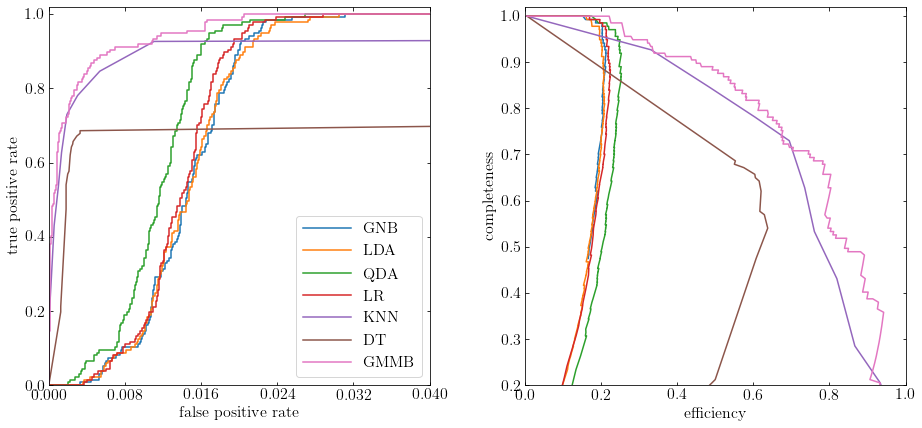

In [4]:
### Modeled after astroML book figure 9.17: 
### https://www.astroml.org/book_figures/chapter9/fig_ROC_curve.html 
from __future__ import print_function
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from astroML.classification import GMMBayes
from astroML.utils import split_samples, completeness_contamination
from astroML.datasets import fetch_rrlyrae_combined
setup_text_plots(fontsize=16, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
y = y.astype(int)
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)
#------------------------------------------------------------
# Fit all the models to the training data
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs


names, probs = compute_models((GaussianNB, {}),
                              (LinearDiscriminantAnalysis, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (LogisticRegression,
                               dict(class_weight='balanced')),
                              (KNeighborsClassifier,
                               dict(n_neighbors=10)),
                              (DecisionTreeClassifier,
                               dict(random_state=0, max_depth=12,
                                    criterion='entropy')),
                              (GMMBayes, dict(n_components=3, tol=1E-5,
                                              covariance_type='full')))

#------------------------------------------------------------
# Plot ROC curves and completeness/efficiency
fig = plt.figure(figsize=(14, 7))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)


# ax2 will show roc curves
ax1 = plt.subplot(121)

# ax1 will show completeness/efficiency
ax2 = plt.subplot(122)

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

thresholds = np.linspace(0, 1, 1001)[:-1]

# iterate through and show results
for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    ax1.plot(fpr, tpr, label=labels[name])

    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax2.plot(1 - cont, comp, label=labels[name])

ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc=4)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0.2, 1.02)

plt.show()

## Generative Classification

In generative classifiers we model class-conditional densities $p_k(\vec{x})$ given $p(\vec{x}|y=y_k)$ 

$p(y=y_k)$, or $\pi_k$ for short, is the probability of any point having class $k$ (equivalent to the prior probability of the class $k$).  

Our goal is to estimate the $p_k$'s 

<u> The discriminative function </u>

$\hat{y} = f(y|\vec{x})$ represents the best guess of $y$ given a value of $\vec{x}$.

$f(y|\vec{x})$ is the _discriminant function_

<u>For a simple 2-class example</u>

> $\begin{eqnarray}
g(\vec{x}) & = &  \int y \, p(y|\vec{x}) \, dy \\
%    & = & \int y p(y|\vec{x}) \, dy \\
       & = & 1 \cdot p(y=1 | \vec{x}) + 0 \cdot p(y=0 | \vec{x}) = p(y=1 | \vec{x}).
%     & = & p(y=1 | \vec{x})
\end{eqnarray}
$

From Bayes rule

> $\begin{eqnarray} g(\vec{x})     & = & \frac{p(\vec{x}|y=1) \, p(y=1)}{p(\vec{x}|y=1) \, p(y=1)  + p(\vec{x}|y=0) \, p(y=0)} \\         & = & \frac{\pi_1 p_1(\vec{x})}{\pi_1 p_1(\vec{x}) + \pi_0 p_0(\vec{x})} \end{eqnarray}$

<u> Bayes Classifier </u>

The discriminant function gives a binary predictor called a Bayes classifier

>$\begin{eqnarray} \widehat{y} & = & \left\{ \begin{array}{cl}       	           1 & \mbox{if $g(\vec{x}) > 1/2$}, \\       	           0 & \mbox{otherwise,}       	           \end{array}       	   \right. \\     & = & \left\{ \begin{array}{cl}               1 & \mbox{if $p(y=1|\vec{x}) > p(y=0|\vec{x})$}, \\               0 & \mbox{otherwise,}               \end{array}       \right. \\     & = & \left\{ \begin{array}{cl}               1 & \mbox{if $\pi_1 p_1(\vec{x}) > \pi_0 p_0(\vec{x})$}, \\               0 & \mbox{otherwise.}               \end{array}       \right.\end{eqnarray}$

<u> Decision Boundary </u>

A set of $x$ values at which each class is equally likely;

>$
\pi_1 p_1(\vec{x}) = \pi_2 p_2(\vec{x});
$

> $g_1(\vec{x}) = g_2(\vec{x})$; $g_1(\vec{x}) - g_2(\vec{x}) = 0$;  $g(\vec{x}) = 1/2$; in a two-class problem
 
<img src="figures/boundary.png">

## Simplest classifier: Naive Bayes

We want $p(x_1,x_2,x_3...x_n|y)$ but if we assume that all attributes are conditionally independent this simplifies to

> $ p(x^i,x^j|y_k) = p(x^i|y)p(x^j|y_k)$
  
which can be written as

> $ p({x^0,x^1,x^2,\ldots,x^N}|y_k) = \prod_i p(x^i|y_k)$

From Bayes' rule and conditional independence we get

> $
  p(y_k | {x^0,x^1,\ldots,x^N}) =
  \frac{\prod_i p(x^i|y_k) p(y_k)}
       {\sum_j \prod_i p(x^i|y_j) p(y_j)}.
$

We calculate the most likely value of $y$ by maximizing over $y_k$,

## $ \widehat{y} = \arg \max_{y_k} \frac{\prod_i p(x^i|y_k) p(y_k)}
        {\sum_j \prod_i p(x^i|y_j) p(y_j)},
$

or

## $\widehat{y} = \arg \max_{y_k} \frac{\prod_i p_k(x^i) \pi_k}
        {\sum_j \prod_i p_j(x^i) \pi_j}.
$

## The rest of the class is now just estimating densities

> <b> $p(\vec{x}|y=y_k)$ and $\pi_k$ are learned from a set of training data.
- $\pi_k$ is just the frequency of the class $k$ in the training set
- $p(\vec{x}|y=y_k)$ is just the density (probability) of a object with class $k$ having the attributes $x$
</b>


If the training set does not cover the full parameter space $p_k(x^i)$ can be $0$ for some value of $y_k$ and $x^i$.  The posterior probability is then $p(y_k|\{x^i\}) = 0/0$ which is unfortunate! The trick is _Laplace smoothing_ : an offset $\alpha$ is added to the probability of each bin $p(\vec{x}|y=y_k)$ for all $i, k$ (equivalent to the addition of a Bayesian prior to the naive Bayes classifier).

## Gaussian Naive Bayes

In Gaussian naive Bayes $p_k(x^i)$ are modeled as one-dimensional normal distributions, with means $\mu^i_k$ and widths $\sigma^i_k$. The naive Bayes estimator is then

# $\hat{y} = \arg\max_{y_k}\left[\ln \pi_k - \frac{1}{2}\sum_{i=1}^N\left(2\pi(\sigma^i_k)^2 + \frac{(x^i - \mu^i_k)^2}{(\sigma^i_k)^2} \right) \right]$

<b> Note: this is the log of the Bayes criterion with no normalization constant </b>

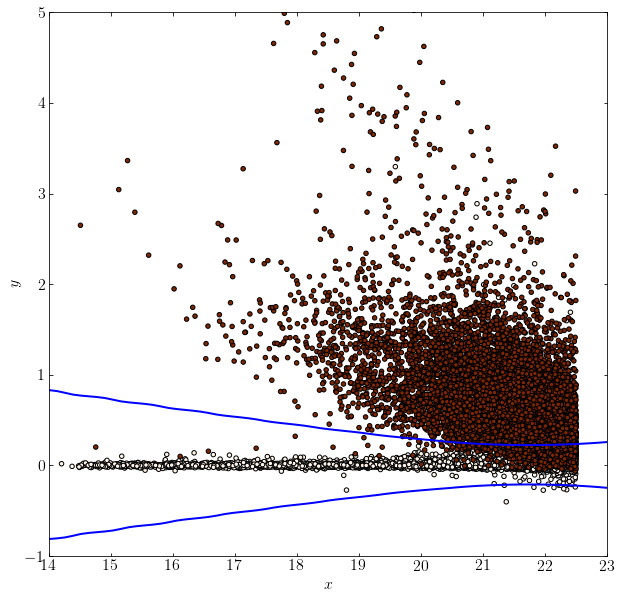

In [20]:
from matplotlib import colors
from astroML.datasets import fetch_imaging_sample
from astroML.plotting.tools import draw_ellipse
from sklearn.naive_bayes import GaussianNB

def get_stars_and_galaxies(Nstars=10000, Ngals=10000):
    """Get the subset of star/galaxy data to plot"""
    data = fetch_imaging_sample()

    objtype = data['type']

    stars = data[objtype == 6][:Nstars]
    
    galaxies = data[objtype == 3][:Ngals]

    return np.concatenate([stars,galaxies]), np.concatenate([np.zeros(len(stars)),np.ones(len(galaxies))])

data, y = get_stars_and_galaxies(Nstars=10000, Ngals=10000)

# select r model mag and psf - model mag as columns
X = np.column_stack((data['rRaw'], data['rRawPSF'] - data['rRaw']))

#------------------------------------------------------------
# Fit the Naive Bayes classifier
clf = GaussianNB()
clf.fit(X, y)

# predict the classification probabilities on a grid
xlim = (14, 23)
ylim = (-1, 5)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Oranges, zorder=2)

ax.contour(xx, yy, Z, [0.5], linewidths=2., colors='blue')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

## GMM and Bayes classification

The natural extension to the Gaussian assumptions is to use GMM's to learn the density distribution. 

The number of Gaussian components $K$ must be chosen for each class independently


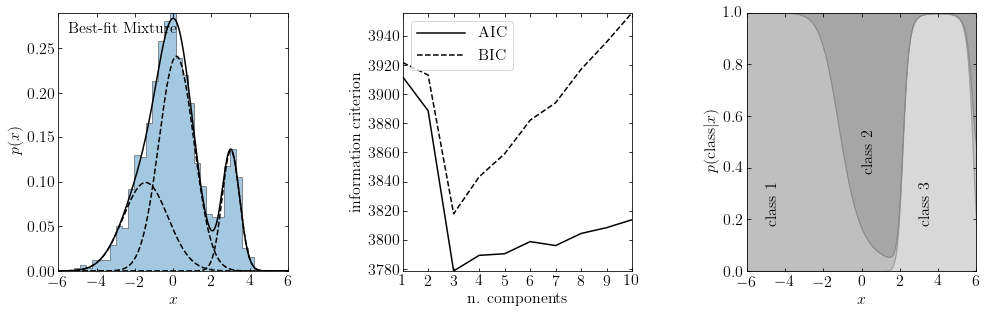

In [23]:
### Modeled after astroML book figure 4.2: 
### https://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html

from sklearn.mixture import GaussianMixture
setup_text_plots(fontsize=16, usetex=True)
#------------------------------------------------------------
# Set up the dataset.
#  We'll create our dataset by drawing samples from Gaussians.
random_state = np.random.RandomState(seed=1)
X = np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1)

#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(15, 5.2))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
M_best = models[np.argmin(AIC)]

x = np.linspace(-6, 6, 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]
 
ax.hist(X, 30, histtype='stepfilled', alpha=0.4, normed=True)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(133)

p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show()

completeness [0.48175182 0.68613139 0.81021898 0.87591241]
contamination [0.85201794 0.79295154 0.80143113 0.79020979]


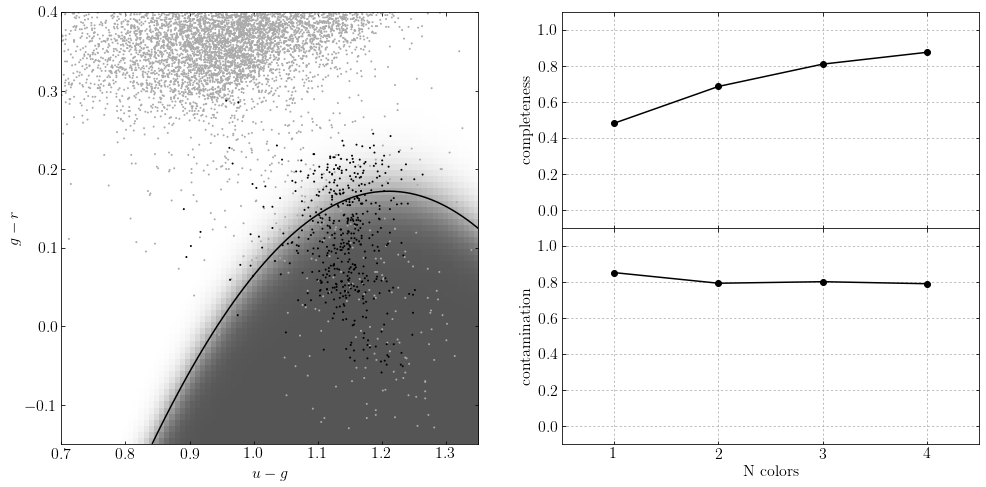

In [9]:
### Modeled after astroML book figure 9.3: 
### https://www.astroml.org/book_figures/chapter9/fig_rrlyrae_naivebayes.html 
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.naive_bayes import GaussianNB
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
setup_text_plots(fontsize=16, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Naive Bayes
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

order = np.array([1, 0, 2, 3])

for nc in Ncolors:
    clf = GaussianNB()
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(15, 7.5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# Plot completeness vs Ncolors
ax = plt.subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# Plot contamination vs Ncolors
ax = plt.subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()


## K-nearest neighbours

As with density estimation (and kernel density estimation)  the intuitive justification is that $p(y|x) \approx p(y|x')$ if $x'$ is very close to $x$.  

The number of neighbors, $K$, regulates the complexity of the classification. In simplest form, a majority rule classification is adopted, where each of the $K$ points votes on the classification. Increasing $K$ decreases the variance in the classification but at the expense of an increase in the bias.  

Weights can be assigned to  individual votes by weighting the vote by the distance to the nearest point.

completeness [[0.22627737 0.3649635  0.46715328 0.54014599]
 [0.00729927 0.23357664 0.40145985 0.53284672]]
contamination [[0.78014184 0.53271028 0.44347826 0.41732283]
 [0.875      0.44827586 0.24657534 0.23958333]]


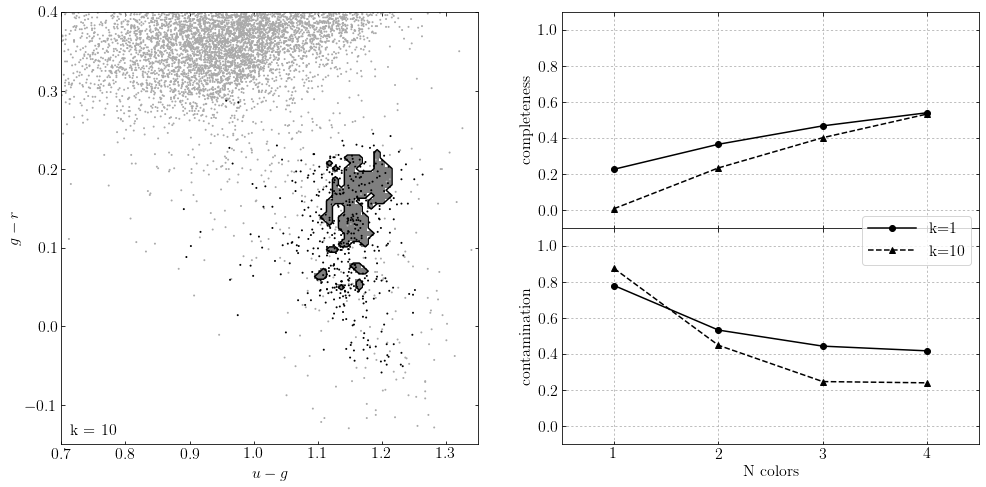

In [10]:
### Modeled after astroML book figure 9.7: 
### https://www.astroml.org/book_figures/chapter9/fig_rrlyrae_knn.html
from __future__ import print_function
from sklearn.neighbors import KNeighborsClassifier
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
setup_text_plots(fontsize=16, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Classification

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
kvals = [1, 10]

for k in kvals:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(15, 7.5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 2)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.text(0.02, 0.02, "k = %i" % kvals[1],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)

ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label='k=%i' % kvals[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, contamination[1], '^--k', ms=6, label='k=%i' % kvals[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

# Discriminative classification

Rather than a probabilistc description we directly model the decision boundary between two or more classes

For a two class example $\{0,1\}$, the discriminant function is given by $g(x) =  p(y=1 | x)$. Once we have it we can use the rule

## $ \widehat{y} = \left\{ \begin{array}{cl}       	           1 & \mbox{if $g(x) > 1/2$}, \\       	           0 & \mbox{otherwise,}       	           \end{array}       	   \right.$

to perform classification.

# Logistic regression

Assuming a binomial logistic regression and consider the linear model

## $
\begin{eqnarray}
  p(y=1|x) &=& \frac{\exp\left[\sum_j \theta_j x^j\right]}
  {1 + \exp\left[\sum_j \theta_j x^j\right]}\nonumber\\
  &=& p({\theta}),
\end{eqnarray}
$

where we define

## $
\mbox{logit}(p_i) = \log\left(\frac{p_i}{1-p_i}\right)
= \sum_j \theta_j x_i^j.
$

The name logistic regression comes from the fact that the function $e^x/(1+e^x)$ is called the logistic function.  
- useful for categorical regression as values cannot go above or below 1 and 0.

Because $y$ is binary, it can be modeled as a Bernoulli distribution with (conditional) likelihood function

## $
L(\beta) = \prod_{i=1}^N p_i(\beta)^{y_i} (1-p_i(\beta))^{1-y_i}.
$

logistic regression is related to linear discriminant analysis (LDA). In LDA

## \begin{eqnarray}
\log\left( \frac{p(y=1|x)}{p(y=0|x)} \right) & = &
  - \frac{1}{2}(\mu_0+\mu_1)^T \Sigma^{-1} (\mu_1-\mu_0) \\ \nonumber
  & + & \log\left( \frac{\pi_0}{\pi_1} \right) + x^T \Sigma^{-1} (\mu_1-\mu_0) \\ \nonumber
  & = & \alpha_0 + \alpha^T x.
\end{eqnarray}

In logistic regression the model is by assumption

## $
\log\left( \frac{p(y=1|x)}{p(y=0|x)} \right) = \beta_0 + \beta^T x.
$

Logistic regression minimizes classification error rather than density estimation error.




## Support Vector Machines
<img style="float: left; width: 50%" src="figures/svm_lines.png"> 
<img style="float: left; width: 50%" src="figures/svm.png">

Find the hyperplane that maximizes the distance of the closest point from either class. This distance is the margin (width of the line before it hits a point). We want the line that maximizes the margin (m).

The points on the margin are called _support vectors_

If we assume $y \in \{-1,1\}$, (+1 is maximum margin, -1 is minimum, 0 is the decision boundary)

The maximum is then just when $\beta_0 + \beta^T x_i = 1$ etc

The hyperplane which maximizes the margin is given by finding

> \begin{equation}
\max_{\beta_0,\beta}(m) \;\;\;
  \mbox{subject to} \;\;\; \frac{1}{||\beta||} y_i ( \beta_0 + \beta^T x_i )
  \geq m \,\,\, \forall \, i.
\end{equation}

The constraints can be written as $y_i ( \beta_0 + \beta^T x_i ) \geq m ||\beta|| $. 

Thus the optimization problem is equivalent to minimizing
> \begin{equation}
\frac{1}{2} ||\beta|| \;\;\; \mbox{subject to} \;\;\; y_i
  ( \beta_0 + \beta^T x_i ) \geq 1 \,\,\, \forall \, i.
\end{equation}

This optimization  is a _quadratic programming_ problem (quadratic objective function with linear constraints)

Note that because SVM uses a metric which maximizes the margin rather than a measure over all points in the data sets, it is similar in spirit to the rank-based estimators 

- The median of a distribution is unaffected by even large perturbations of outlying points, as long as those perturbations do not cross the boundary.
- In the same way, once the support vectors are determined, changes to the positions or numbers of points beyond the margin will not change the decision boundary.  For this reason, SVM can be a very powerful tool for discriminative classification.

- This is why there is a high completeness compared to the other methods: it does not matter that the background sources outnumber the RR Lyrae stars by a factor of $\sim$200 to 1. It simply determines the best boundary between the small RR Lyrae clump and the large background clump.
- This completeness, however, comes at the cost of a relatively large contamination level.

- SVM is not scale invariant so it often worth rescaling the data to [0,1] or to whiten it to have a mean of 0 and variance 1 (remember to do this to the test data as well!)
- The data dont need to be separable (we can put a constraint in minimizing the number of "failures")

@pickle_results: computing results and saving to 'SVM_rrlyrae.pkl'
completeness [0.99270073 1.         1.         1.        ]
contamination [0.90014684 0.85347594 0.85347594 0.85471898]


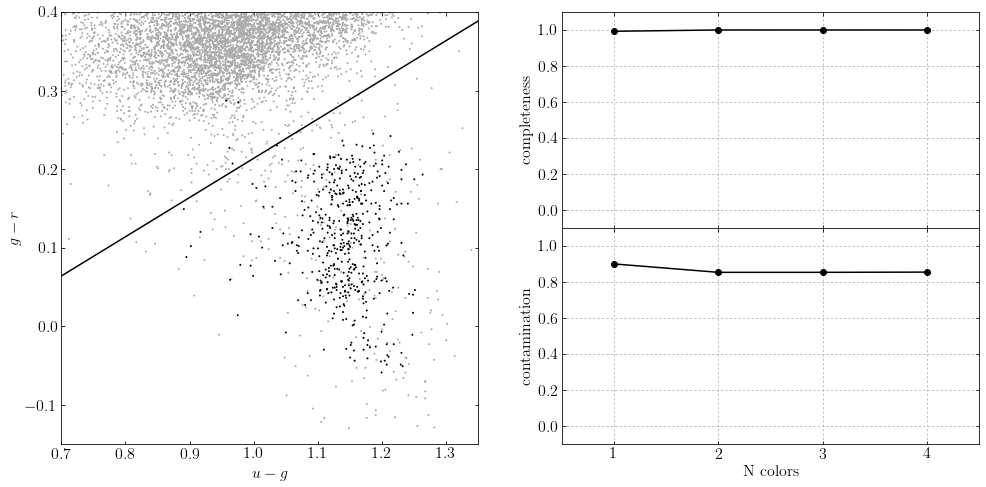

In [13]:
### Modeled after astroML book figure 9.10: 
### https://www.astroml.org/book_figures/chapter9/fig_rrlyrae_svm.html
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
setup_text_plots(fontsize=16, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results

# SVM takes several minutes to run, and is order[N^2]
#  truncating the dataset can be useful for experimentation.
#X = X[::5]
#y = y[::5]

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# Fit SVM
Ncolors = np.arange(1, X.shape[1] + 1)


@pickle_results('SVM_rrlyrae.pkl')
def compute_SVM(Ncolors):
    classifiers = []
    predictions = []

    for nc in Ncolors:
        # perform support vector classification
        clf = SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_SVM(Ncolors)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# compute the decision boundary
clf = classifiers[1]
w = clf.coef_[0]
a = -w[0] / w[1]
yy = np.linspace(-0.1, 0.4)
xx = a * yy - clf.intercept_[0] / w[1]

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(15, 7.5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
ax.plot(xx, yy, '-k')
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

ax.set_xlim(0.7, 1.35)
ax.set_ylim(-0.15, 0.4)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

## Decision Trees

The hierarchical application of decision boundaries lead to _decision trees_

Tree structure:
- top node contains the entire data set
- at each branch the data are subdivided into two child nodes 
- split is based on a predefined decision boundary (usually axis aligned)
- splitting repeats, recursively, until we reach a predefined stopping criteria 

<img src="figures/decision.png">

The "leaf nodes" record the fraction of points that have one classification or the other

Application of the tree to classification is simple (a series of binary decisions). The  fraction of points from the training set classified as one class or the other (in the leaf node) defines the class associated with that leaf node.

Decision trees are simple to interpret (a set of questions)

## Splitting Criteria

In order to build a decision tree we must choose the feature and
value on which we wish to split the data.


## Information content or entropy of the data

> $
    E(x) = -\sum_i p_i(x) \ln (p_i(x)),
$

where $i$ is the class and $p_i(x)$ is the probability of that class
given the training data. 

Information gain is the reduction in entropy due to the partitioning of the data 

For a binary split $IG(x)$ is

> $ IG(x|x_i) = E(x) - \sum_{i=0}^{1} \frac{N_i}{N}  E(x_i), $

where $N_i$ is the number of points, $x_i$, in the $i$th class,
and $E(x_i)$ is the entropy associated with that class

Search for the split is undertaken in a greedy fashion (one attribute at a time) where we sort the data on feature $i$ and maximize the information gain for a given split point, $s$,

>$
IG(x|s) = E(x) - \arg\max_s \left( \frac{N(x|x<s)}{N}  E(x|x<s) -
  \frac{N(x|x\ge s)}{N}  E(x|x\ge s)  \right ).
$

To determine the depth of the tree we use cross validation

ERROR! Session/line number was not unique in database. History logging moved to new session 3624
completeness [[0.00729927 0.3649635  0.29927007 0.62773723]
 [0.02189781 0.31386861 0.51824818 0.57664234]]
contamination [[0.66666667 0.375      0.31666667 0.31746032]
 [0.625      0.48809524 0.37719298 0.3875969 ]]


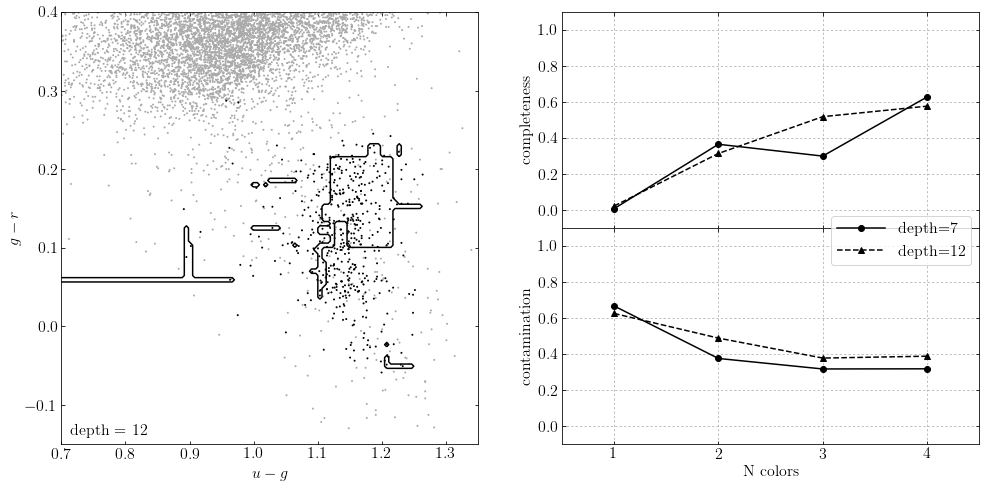

In [14]:
### Modeled after astroML book figure 9.13: 
### https://www.astroml.org/book_figures/chapter9/fig_rrlyrae_decisiontree.html
from __future__ import print_function

from sklearn.tree import DecisionTreeClassifier
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
setup_text_plots(fontsize=16, usetex=True)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)
N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# Fit Decision tree
Ncolors = np.arange(1, X.shape[1] + 1)

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
depths = [7, 12]

for depth in depths:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = DecisionTreeClassifier(random_state=0, max_depth=depth,
                                     criterion='entropy')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# compute the decision boundary

clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(15, 7.5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.text(0.02, 0.02, "depth = %i" % depths[1],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label="depth=%i" % depths[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', ms=6, label="depth=%i" % depths[0])
ax.plot(Ncolors, contamination[1], '^--k', ms=6, label="depth=%i" % depths[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

## Alright, alright but what the @#%! should I use?

A convenient cop-out: no single model can be known in advance to be the best classifier!

In general the level of accuracy increases for parametric models as:
- <b>naive Bayes</b>, 
- linear discriminant analysis (LDA),
- logistic regression, 
- linear support vector machines, 
- quadratic discriminant analysis (QDA),
- linear ensembles of linear models. 

For non-parametric models accuracy increases as:
- decision trees
- $K$-nearest-neighbor, 
- neural networks
- kernel discriminant analysis,
- <b> kernelized support vector machines</b>
- <b> random forests</b>
- boosting

Naive Bayes and its variants are by far the easiest to compute. Linear support vector machines are more expensive, though several fast algorithms exist. Random forests can be easily parallelized. 

